In [19]:
# ============================================================
# 10,000 MONTE CARLO FULL-SEASON SIMULATION
# ============================================================

N_SEASONS = 10000

# Storage for results
all_results = {team: [] for team in teams_2526}

def simulate_single_season():
    """
    Simulates ALL remaining fixtures for ONE season.
    Uses the improved expected-goals model + Monte Carlo.
    Returns final table as a DataFrame.
    """
    sim = laliga_2526.copy()

    # For all matches not played yet:
    rem_mask = sim["Status"] != "FULL_TIME"

    sim_home = []
    sim_away = []

    for _, row in sim[rem_mask].iterrows():
        home = row["Home Team"]
        away = row["Away Team"]
        lam_h, lam_a = expected_goals_improved(home, away)

        # Poisson goals
        hg = np.random.poisson(lam_h)
        ag = np.random.poisson(lam_a)

        sim_home.append(hg)
        sim_away.append(ag)

    sim.loc[rem_mask, "Home Goal"] = sim_home
    sim.loc[rem_mask, "Away Goal"] = sim_away

    # Compute table for this season
    table = {}

    for _, row in sim.iterrows():
        home = row["Home Team"]
        away = row["Away Team"]
        hg = int(row["Home Goal"])
        ag = int(row["Away Goal"])

        for t in (home, away):
            if t not in table:
                table[t] = {
                    "Team": t, "MP": 0, "W": 0, "D": 0, "L": 0,
                    "GF": 0, "GA": 0, "Pts": 0
                }

        table[home]["MP"] += 1
        table[away]["MP"] += 1
        table[home]["GF"] += hg
        table[home]["GA"] += ag
        table[away]["GF"] += ag
        table[away]["GA"] += hg

        if hg > ag:
            table[home]["W"] += 1; table[away]["L"] += 1
            table[home]["Pts"] += 3
        elif hg < ag:
            table[away]["W"] += 1; table[home]["L"] += 1
            table[away]["Pts"] += 3
        else:
            table[home]["D"] += 1; table[away]["D"] += 1
            table[home]["Pts"] += 1; table[away]["Pts"] += 1

    df = pd.DataFrame(table.values())
    df["GD"] = df["GF"] - df["GA"]
    df = df.sort_values(["Pts", "GD", "GF"], ascending=False).reset_index(drop=True)
    return df


# ============================================================
# RUN THE MONTE CARLO
# ============================================================
print("Running 10,000 simulations... (this takes ~20–40 seconds)")

champions = []
top4_counts = {team: 0 for team in teams_2526}
relegation_counts = {team: 0 for team in teams_2526}
points_distributions = {team: [] for team in teams_2526}

for i in range(N_SEASONS):
    df = simulate_single_season()

    # Champion
    champion = df.iloc[0]["Team"]
    champions.append(champion)

    # Top 4
    for t in df.iloc[:4]["Team"]:
        top4_counts[t] += 1

    # Relegation (bottom 3)
    for t in df.iloc[-3:]["Team"]:
        relegation_counts[t] += 1

    # Points distribution
    for _, row in df.iterrows():
        points_distributions[row["Team"]].append(row["Pts"])

    if (i + 1) % 1000 == 0:
        print(f"  {i+1} / {N_SEASONS} seasons done")


# ============================================================
# BUILD PROBABILITY TABLE
# ============================================================
prob_table = []

for team in teams_2526:
    prob_table.append({
        "Team": team,
        "Champion%": champions.count(team) / N_SEASONS * 100,
        "Top4%": top4_counts[team] / N_SEASONS * 100,
        "Relegation%": relegation_counts[team] / N_SEASONS * 100,
        "AvgPoints": np.mean(points_distributions[team]),
        "StdPoints": np.std(points_distributions[team]),
    })

prob_df = pd.DataFrame(prob_table)
prob_df = prob_df.sort_values("Champion%", ascending=False).reset_index(drop=True)

print("\n===== PROBABILITY TABLE (MONTE CARLO 10,000 SEASONS) =====\n")
print(prob_df)

# Save results
prob_df.to_csv(f"{OUTPUT_PREFIX}_monte_carlo_probabilities.csv", index=False)
print("\nSaved probability table.")


Running 10,000 simulations... (this takes ~20–40 seconds)


NameError: name 'expected_goals_improved' is not defined

In [22]:
import pandas as pd
import numpy as np

df = pd.read_csv('la_liga_2025_26_monte_carlo_probabilities.csv')

N = 10000  # change if you used a different number of simulations

def add_confidence_intervals(df, column, N):
    p = df[column] / 100
    se = np.sqrt(p * (1 - p) / N)
    df[column + "_CI_low"]  = (p - 1.96 * se) * 100
    df[column + "_CI_high"] = (p + 1.96 * se) * 100
    return df

df = add_confidence_intervals(df, "Champion%", N)
df = add_confidence_intervals(df, "Top4%", N)
df = add_confidence_intervals(df, "Relegation%", N)

df.head()



,Team,Champion%,Top4%,Relegation%,AvgPoints,StdPoints,Champion%_CI_low,Champion%_CI_high,Top4%_CI_low,Top4%_CI_high,Relegation%_CI_low,Relegation%_CI_high
0,Real Madrid,43.37,99.64,0.00,84.0147,6.013342,42.398654,44.341346,99.522612,99.757388,0.000000,0.000000
1,FC Barcelona,42.00,99.59,0.00,83.4674,5.810330,41.032625,42.967375,99.464756,99.715244,0.000000,0.000000
2,Atletico Madrid,8.19,96.72,0.00,76.7787,5.933138,7.652544,8.727456,96.370899,97.069101,0.000000,0.000000
3,Villarreal CF,6.42,95.62,0.00,75.8532,6.044109,5.939587,6.900413,95.218886,96.021114,0.000000,0.000000
4,Athletic Club,0.01,1.85,0.09,56.3075,6.321957,-0.009599,0.029599,1.585889,2.114111,0.031226,0.148774


In [23]:
from math import erf, sqrt

def compare_two_teams(df, teamA, teamB, N):
    A = df[df.Team == teamA].iloc[0]
    B = df[df.Team == teamB].iloc[0]
    
    pA = A["Champion%"] / 100
    pB = B["Champion%"] / 100
    
    diff = pA - pB
    se = np.sqrt(pA*(1-pA)/N + pB*(1-pB)/N)
    
    z = diff / se
    p_value = 2 * (1 - 0.5*(1 + erf(abs(z)/sqrt(2))))
    
    return {
        "pA": pA,
        "pB": pB,
        "difference": diff,
        "z_score": z,
        "p_value": p_value
    }

compare_two_teams(df, "Real Madrid", "FC Barcelona", N)


{'pA': np.float64(0.4337),
 'pB': np.float64(0.42),
 'difference': np.float64(0.01369999999999999),
 'z_score': np.float64(1.9587338552746185),
 'p_value': 0.05014396342411098}


=== One Sample Season (Real MD1–12 + Simulated MD13–38) ===
                    MP   W   D   L  GF  GA  GD  Pts
Team                                               
Real Madrid         38  26   6   6  80  38  42   84
FC Barcelona        38  22   6  10  76  56  20   72
Villarreal CF       38  21   8   9  70  33  37   71
Atlético de Madrid  38  19  13   6  71  45  26   70
Real Betis          38  18  12   8  62  43  19   66
Deportivo Alavés    38  15  13  10  46  33  13   58
Getafe CF           38  14  10  14  40  48  -8   52
Levante UD          38  14   9  15  63  57   6   51
CA Osasuna          38  14   9  15  37  38  -1   51
Rayo Vallecano      38  13  11  14  35  39  -4   50
Elche CF            38  11  16  11  38  40  -2   49
Sevilla FC          38  13  10  15  45  48  -3   49
Real Sociedad       38  13   9  16  51  50   1   48
Athletic Club       38  12   9  17  42  54 -12   45
Valencia CF         38  10  15  13  37  57 -20   45
RC Celta            38   9  16  13  51  64 -13   43
RCD

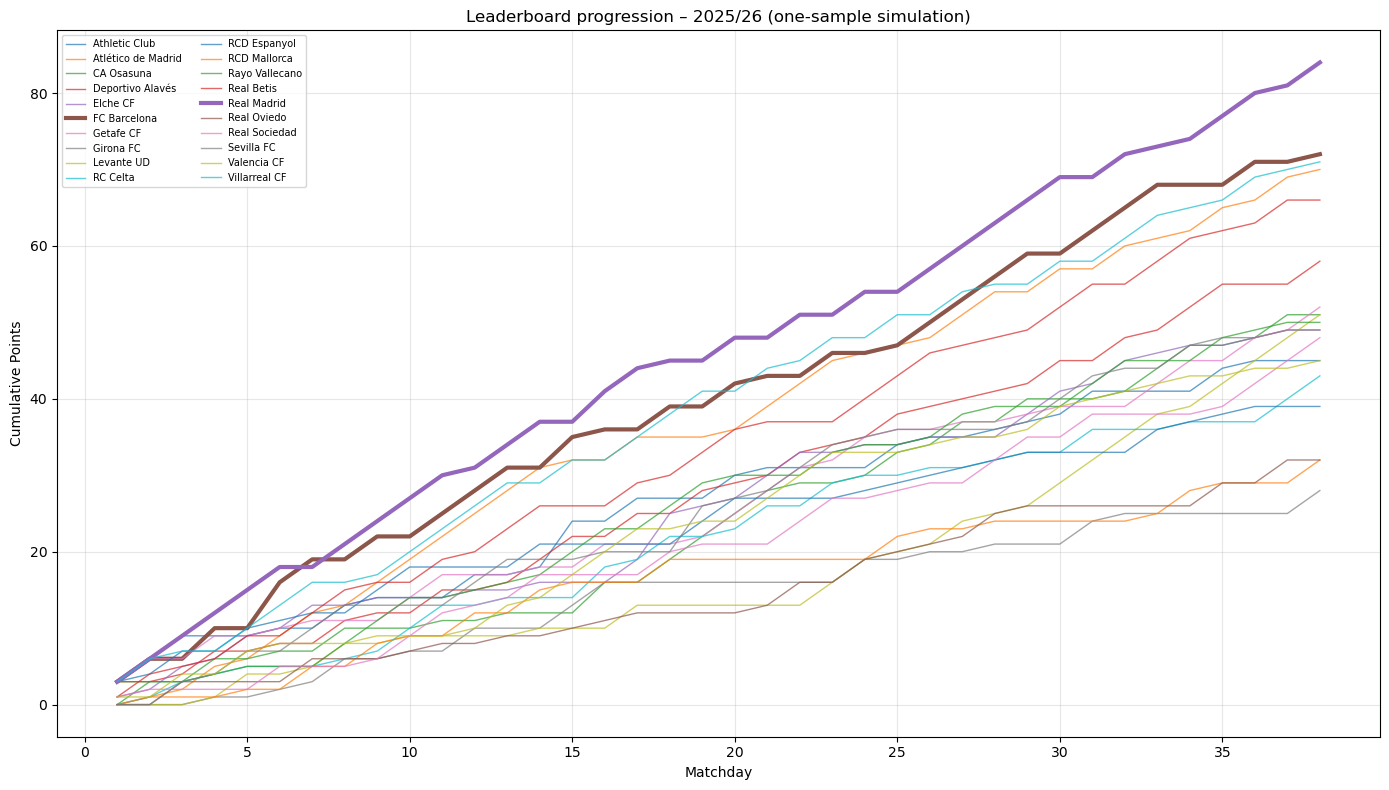

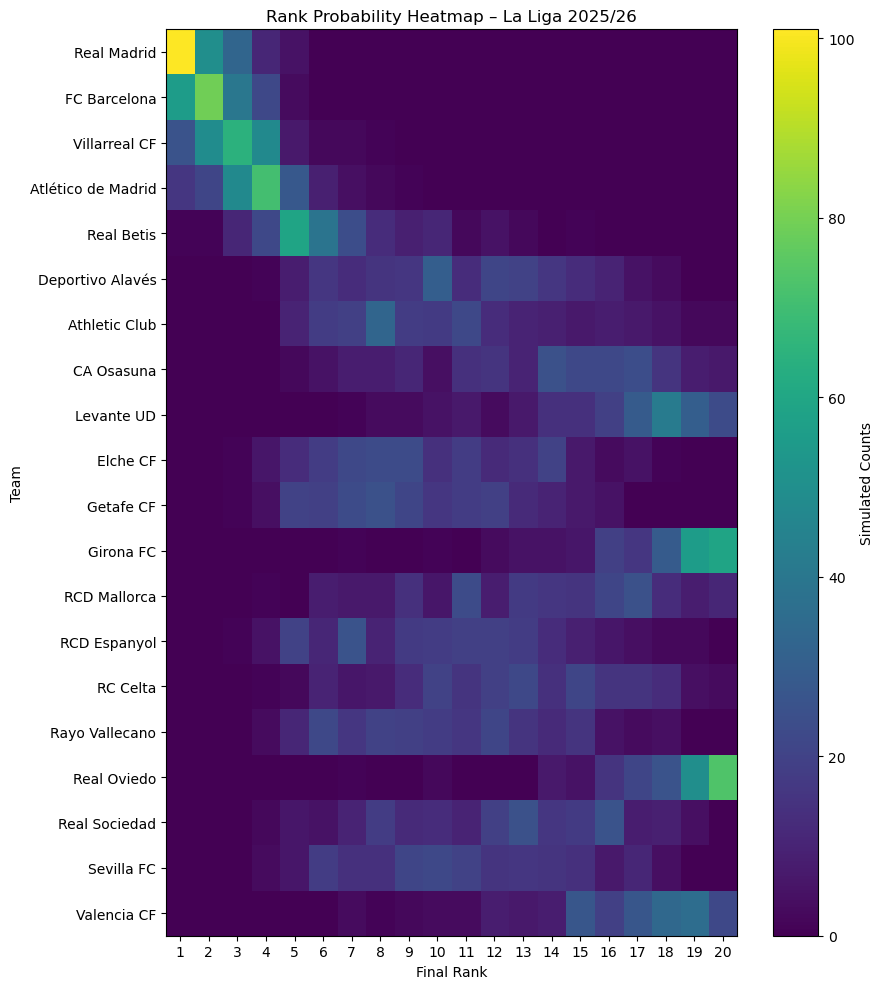

In [ ]:
#import and configurations
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path(".")                  # Folder where Excel files are located
MATCHDAY_CUTOFF = 12                  # Real data up to MD12; simulations from MD13–38
N_SIMULATIONS = 200                # Number of Monte Carlo runs (10k as in paper)
RANDOM_SEED = 42                      # Reproducible randomness
np.random.seed(RANDOM_SEED)

#data class for team stats
@dataclass
class TeamStats:
   
    team: str
    home_goals_for: float
    home_goals_against: float
    away_goals_for: float
    away_goals_against: float
    home_matches: int
    away_matches: int

    #Convenience properties for computing per-match averages
    @property
    def avg_home_scored(self) -> float:
        return self.home_goals_for / max(self.home_matches, 1)

    @property
    def avg_home_conceded(self) -> float:
        return self.home_goals_against / max(self.home_matches, 1)

    @property
    def avg_away_scored(self) -> float:
        return self.away_goals_for / max(self.away_matches, 1)

    @property
    def avg_away_conceded(self) -> float:
        return self.away_goals_against / max(self.away_matches, 1)

#Loading & Preprocessing the Excel4Soccer Data
def load_fixtures_2025_26() -> pd.DataFrame:
    
    xls = pd.ExcelFile(DATA_DIR / "Soccer-Stats-La-Liga-2025-2026.xlsx")
    df = pd.read_excel(xls, "fixtures")
    df = df[df["Stage"] == "REGULAR_SEASON"].copy()
    return df
def split_observed_and_future(fixtures: pd.DataFrame):
    observed = fixtures[
        (fixtures["Match Day"] <= MATCHDAY_CUTOFF) &
        (fixtures["Status"] == "FULL_TIME")
    ].copy()

    future = fixtures[fixtures["Match Day"] > MATCHDAY_CUTOFF].copy()
    return observed, future

# Estimating Team Strengths (Poisson Model Inputs)
def compute_team_strengths(observed: pd.DataFrame) -> Dict[str, TeamStats]:
    """
    Compute each team's offensive and defensive strength based only on
    Matchdays 1–12 and 24/25 season.

    These estimates follow the formula in the paper:
        λ_home = (avg_home_scored + avg_away_conceded) / 2
        λ_away = (avg_away_scored + avg_home_conceded) / 2
    """
    teams = sorted(set(observed["Home Team"]).union(observed["Away Team"]))
    strengths = {}

    for t in teams:
        home = observed[observed["Home Team"] == t]
        away = observed[observed["Away Team"] == t]

        strengths[t] = TeamStats(
            team=t,
            home_goals_for     = home["Home Goal"].sum(),
            home_goals_against = home["Away Goal"].sum(),
            away_goals_for     = away["Away Goal"].sum(),
            away_goals_against = away["Home Goal"].sum(),
            home_matches       = len(home),
            away_matches       = len(away),
        )

    return strengths


def expected_goals_for_fixture(row: pd.Series, strengths: Dict[str, TeamStats]):
    """
    Compute expected home and away goals for one match fixture using
    the Poisson model averaging structure described in the paper.
    """
    home = strengths[row["Home Team"]]
    away = strengths[row["Away Team"]]

    lam_home = (home.avg_home_scored + away.avg_away_conceded) / 2
    lam_away = (away.avg_away_scored + home.avg_home_conceded) / 2

    #Prevent degenerate Poisson distributions:
    lam_home = max(lam_home, 0.05)
    lam_away = max(lam_away, 0.05)

    return lam_home, lam_away

#League Table Functions
def initialise_table(teams: List[str]) -> pd.DataFrame:
    return pd.DataFrame(
        {"Team": teams, "MP": 0, "W": 0, "D": 0, "L": 0, "GF": 0, "GA": 0, "GD": 0, "Pts": 0}
    ).set_index("Team")

def apply_result_to_table(table, home_team, away_team, home_goals, away_goals):
    """Update league table with one match result."""
    #Update match count + goals
    table.loc[home_team, ["MP", "GF", "GA"]] += [1, home_goals, away_goals]
    table.loc[away_team, ["MP", "GF", "GA"]] += [1, away_goals, home_goals]

    #Update Win/Draw/Loss + Points
    if home_goals > away_goals:
        table.loc[home_team, ["W", "Pts"]] += [1, 3]
        table.loc[away_team, "L"] += 1
    elif home_goals < away_goals:
        table.loc[away_team, ["W", "Pts"]] += [1, 3]
        table.loc[home_team, "L"] += 1
    else:
        table.loc[home_team, ["D", "Pts"]] += [1, 1]
        table.loc[away_team, ["D", "Pts"]] += [1, 1]

    #Always keep goal difference updated
    table["GD"] = table["GF"] - table["GA"]


def sort_table(table: pd.DataFrame) -> pd.DataFrame:
    """Sort table by points, then goal difference, then goals for."""
    return table.sort_values(["Pts", "GD", "GF"], ascending=False)


#progression graph data
def build_observed_base_table_and_progression(observed, teams, max_matchday):
    """
    Construct the league table after Matchday 12 using real results.
    Also construct the progression table for plotting:
        progression[matchday][team] = cumulative points
    """
    table = initialise_table(teams)
    progression = pd.DataFrame(index=range(1, max_matchday + 1), columns=teams)

    #Apply real MD1–12 results matchday by matchday
    for md, md_matches in observed.groupby("Match Day"):
        for _, row in md_matches.iterrows():
            apply_result_to_table(
                table,
                row["Home Team"], row["Away Team"],
                int(row["Home Goal"]), int(row["Away Goal"])
            )

        #Store cumulative points at end of this matchday
        for t in teams:
            progression.loc[md, t] = table.loc[t, "Pts"]

    return table, progression

def simulate_rest_of_season_once(base_table, future, strengths, teams, progression_obs):
    """
    Produce ONE simulated season.

    """

    #Always copy the base real MD1–12 table
    table = base_table.copy(deep=True)

    #If progression_obs is None → Monte Carlo mode (no progression tracking)
    if progression_obs is None:
        track_progression = False
        progression = None
    else:
        track_progression = True
        progression = progression_obs.copy(deep=True)

    #Simulate matchdays 13–38
    for md, md_matches in future.groupby("Match Day"):
        for _, row in md_matches.iterrows():

            #Expected goals via Poisson model
            lam_home, lam_away = expected_goals_for_fixture(row, strengths)
            home_goals = np.random.poisson(lam_home)
            away_goals = np.random.poisson(lam_away)

            #Update league table
            apply_result_to_table(table, row["Home Team"], row["Away Team"],
                                  home_goals, away_goals)

        #Track progression only in the single example simulation
        if track_progression:
            for t in teams:
                progression.loc[md, t] = table.loc[t, "Pts"]

    #Always return final sorted table
    return sort_table(table), progression


#Monte Carlo Simulation (10,000 Seasons)
def run_monte_carlo(base_table, future, strengths, teams, n_sim=N_SIMULATIONS):
    n_teams = len(teams)

    #Track how many times each team finishes in each rank 1–20
    rank_counts = pd.DataFrame(0, index=teams, columns=range(1, n_teams + 1), dtype=int)

    champions = pd.Series(0, index=teams)
    top4 = pd.Series(0, index=teams)
    releg = pd.Series(0, index=teams)

    pts_sum = pd.Series(0.0, index=teams)
    pts_sq_sum = pd.Series(0.0, index=teams)

    for i in range(n_sim):
        final_table, _ = simulate_rest_of_season_once(
            base_table, future, strengths, teams, progression_obs=None
        )

        final_table = final_table.reset_index()

        #Assign rank counts
        for rank, row in final_table.iterrows():
            team = row["Team"]
            r = rank + 1
            pts = row["Pts"]

            rank_counts.loc[team, r] += 1
            pts_sum[team] += pts
            pts_sq_sum[team] += pts**2

            if r == 1:
                champions[team] += 1
            if r <= 4:
                top4[team] += 1
            if r >= 18:
                releg[team] += 1

        #Progress indicator every 10%
        if (i + 1) % (n_sim // 10) == 0:
            print(f"Completed {i + 1}/{n_sim} simulations")

    #Build final probability table
    probs = pd.DataFrame({
        "Champion%": champions / n_sim * 100,
        "Top4%": top4 / n_sim * 100,
        "Relegation%": releg / n_sim * 100,
        "AvgPoints": pts_sum / n_sim,
        "StdPoints": np.sqrt((pts_sq_sum / n_sim) - (pts_sum / n_sim) ** 2),
    })

    #Sort by championship probability (like in your Results table)
    probs = probs.sort_values("Champion%", ascending=False)

    #Ensure heatmap follows the same sorted order
    rank_counts = rank_counts.loc[probs.index]

    return probs, rank_counts

#leaderboard progression plot
def plot_leaderboard_progression(progression, title):
    """
    Plot cumulative league points across matchdays.
    - MD1–12 = real results
    - MD13–38 = simulated
    """
    plt.figure(figsize=(14, 8))

    for team in progression.columns:
        #Highlight Real Madrid vs Barcelona rivalry
        if team in ["Real Madrid", "FC Barcelona"]:
            lw, alpha = 3.0, 1.0
        else:
            lw, alpha = 1.0, 0.7

        plt.plot(progression.index, progression[team].astype(float),
                 label=team, linewidth=lw, alpha=alpha)

    plt.title(title)
    plt.xlabel("Matchday")
    plt.ylabel("Cumulative Points")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=7, ncol=2)
    plt.tight_layout()


def plot_rank_heatmap(rank_counts, title):
    """
    Plot the distribution of finishing positions across Monte Carlo runs.
    The diagonal shows each team's most common ranking zone.
    """
    plt.figure(figsize=(9, 10))
    img = plt.imshow(rank_counts.values, aspect="auto", origin="upper")
    plt.colorbar(img, label="Simulated Counts")

    plt.xticks(range(20), range(1, 21))
    plt.yticks(range(len(rank_counts.index)), rank_counts.index)
    plt.title(title)
    plt.xlabel("Final Rank")
    plt.ylabel("Team")
    plt.tight_layout()

#Main Pipeline
def main():
    """
    Full workflow:
    1. Load data
    2. Estimate strengths
    3. Build real MD1–12 table
    4. Simulate one full season for the visual example
    5. Run Monte Carlo (10k)
    6. Export results and produce plots
    """
    fixtures = load_fixtures_2025_26()
    observed, future = split_observed_and_future(fixtures)
    teams = sorted(set(observed["Home Team"]).union(observed["Away Team"]))

    #Step 1: Compute MD1–12 strengths
    strengths = compute_team_strengths(observed)

    #Step 2: Build base table and progression from real results
    base_table, progression_obs = build_observed_base_table_and_progression(
        observed, teams, max_matchday=int(future["Match Day"].max())
    )

    #Step 3: Generate one example simulated season (used for the graph)
    final_table_sample, progression = simulate_rest_of_season_once(
        base_table, future, strengths, teams, progression_obs
    )

    print("\n=== One Sample Season (Real MD1–12 + Simulated MD13–38) ===")
    print(final_table_sample)

    plot_leaderboard_progression(
        progression,
        "Leaderboard progression – 2025/26 (one-sample simulation)"
    )

    #Step 4: Monte Carlo Simulation (10,000 repetitions)
    print("\nRunning Monte Carlo Simulation…")
    probs, rank_counts = run_monte_carlo(
        base_table, future, strengths, teams, n_sim=N_SIMULATIONS
    )

    print("\n=== Monte Carlo Probability Table ===")
    print(probs)

    #Save outputs exactly like in your paper
    probs.to_csv("la_liga_2025_26_monte_carlo_probabilities_generated.csv")
    rank_counts.to_csv("la_liga_2025_26_rank_counts_generated.csv")

    #Plot heatmap (rank probability distribution)
    plot_rank_heatmap(rank_counts, "Rank Probability Heatmap – La Liga 2025/26")

    plt.show()


#Run script if executed directly
if __name__ == "__main__":
    main()
